# Project 2 - LendingClub
## OPAN 6604 - Predictive Analytics
Mike Johnson - SAXA

****

## Set Up

In [114]:
# Import libraries

# Data Processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Explainability
from sklearn.inspection import permutation_importance
import lime
import lime.lime_tabular

In [ ]:
# Load dataset
df = pd.read_csv('LC_HW2.csv')

df.head()

all_util  annual_inc application_type  chargeoff_within_12_mths  \
0      80.0     36000.0       Individual                         0   
1      61.0     45000.0       Individual                         0   
2      31.0     53040.0       Individual                         0   
3      87.0    125000.0       Individual                         0   
4      75.0     73000.0       Individual                         0   

   collections_12_mths_ex_med  delinq_2yrs    dti emp_length  fico_range_high  \
0                           0            0  26.33        NaN              674   
1                           0            0  38.51     1 year              734   
2                           0            0  25.20   < 1 year              809   
3                           0            0  27.87  10+ years              684   
4                           0            0  35.12  10+ years              759   

   fico_range_low  ... mo_sin_old_rev_tl_op  mort_acc  mths_since_last_record  \
0             670  ...                   35         0                     NaN   
1             730  ...                  103         0                     NaN   
2             805  ...                  145         4                     NaN   
3             680  ...                  230         4                     NaN   
4             755  ...                  126         1                     NaN   

   mths_since_recent_inq  open_acc  pub_rec_bankruptcies        term  \
0                    0.0         5                     0   36 months   
1                    0.0        14                     0   60 months   
2                    0.0         9                     0   36 months   
3                   19.0        14                     0   36 months   
4                   13.0        19                     0   36 months   

   total_bal_ex_mort  verification_status  int_rate  
0              34683             Verified     18.62  
1              63873         Not Verified     16.08  
2              24452             Verified      7.56  
3             141033             Verified     17.30  
4             160302         Not Verified     10.81  

[5 rows x 24 columns]

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   all_util                    99984 non-null   float64
 1   annual_inc                  100000 non-null  float64
 2   application_type            100000 non-null  object 
 3   chargeoff_within_12_mths    100000 non-null  int64  
 4   collections_12_mths_ex_med  100000 non-null  int64  
 5   delinq_2yrs                 100000 non-null  int64  
 6   dti                         99814 non-null   float64
 7   emp_length                  91331 non-null   object 
 8   fico_range_high             100000 non-null  int64  
 9   fico_range_low              100000 non-null  int64  
 10  home_ownership              100000 non-null  object 
 11  inq_last_12m                100000 non-null  int64  
 12  loan_amnt                   100000 non-null  int64  
 13  mo_sin_old_il_a

### One Hot Encoding

Creating dummy variables for categorical variables. We'll save emp_length for later. This will be converted to numerical.

In [117]:
# Define categorical variables for one-hot encoding
cat_cols = ['application_type', 'home_ownership', 'term', 'verification_status']

# Initialize OneHotEncoder and drop the first dummy
ohe = OneHotEncoder(drop='first')

# Fit and transform the categorical column(s)
ohe_features = ohe.fit_transform(df[cat_cols]).toarray()

# Get the dummy column names from the encoder
ohe_labels = ohe.get_feature_names_out(cat_cols)

# Convert encoded output into a DataFrame
ohe_features = pd.DataFrame(ohe_features, columns=ohe_labels)

# Create a copy of the original DataFrame without the original categorical column(s)
df_nocat = df.drop(columns=cat_cols)

# Attach the dummy variable DataFrame to the rest of the dataset
df_encoded = pd.concat([df_nocat, ohe_features], axis=1)

# Final encoded dataset
df_encoded

all_util  annual_inc  chargeoff_within_12_mths  \
0          80.0     36000.0                         0   
1          61.0     45000.0                         0   
2          31.0     53040.0                         0   
3          87.0    125000.0                         0   
4          75.0     73000.0                         0   
...         ...         ...                       ...   
99995      75.0     38500.0                         0   
99996      59.0    165000.0                         0   
99997      54.0     49999.0                         0   
99998      54.0     62800.0                         0   
99999      51.0     55000.0                         0   

       collections_12_mths_ex_med  delinq_2yrs    dti emp_length  \
0                               0            0  26.33        NaN   
1                               0            0  38.51     1 year   
2                               0            0  25.20   < 1 year   
3                               0            0  27.87  10+ years   
4                               0            0  35.12  10+ years   
...                           ...          ...    ...        ...   
99995                           0            0  51.75    2 years   
99996                           0            3  12.90    6 years   
99997                           0            0  32.67   < 1 year   
99998                           0            0  33.86     1 year   
99999                           0            0  32.62  10+ years   

       fico_range_high  fico_range_low  inq_last_12m  ...  \
0                  674             670             5  ...   
1                  734             730             1  ...   
2                  809             805             1  ...   
3                  684             680             0  ...   
4                  759             755             0  ...   
...                ...             ...           ...  ...   
99995              664             660             1  ...   
99996              714             710             0  ...   
99997              664             660             0  ...   
99998              759             755             3  ...   
99999              674             670             3  ...   

       mths_since_recent_inq  open_acc  pub_rec_bankruptcies  \
0                        0.0         5                     0   
1                        0.0        14                     0   
2                        0.0         9                     0   
3                       19.0        14                     0   
4                       13.0        19                     0   
...                      ...       ...                   ...   
99995                    6.0        17                     0   
99996                   14.0        14                     0   
99997                    NaN        14                     0   
99998                    1.0        15                     0   
99999                    1.0        18                     0   

       total_bal_ex_mort  int_rate  application_type_Joint App  \
0                  34683     18.62                         0.0   
1                  63873     16.08                         0.0   
2                  24452      7.56                         0.0   
3                 141033     17.30                         0.0   
4                 160302     10.81                         0.0   
...                  ...       ...                         ...   
99995              45338     18.62                         1.0   
99996              55842      8.19                         0.0   
99997              36970     17.74                         0.0   
99998              92636      8.19                         0.0   
99999              40729     16.95                         0.0   

       home_ownership_OWN  home_ownership_RENT  term_ 60 months  \
0                     1.0                  0.0              0.0   
1                     0.0                  1.0              1.0   
2        

****

## Train / Test Split

In [118]:
# Define features / target
X = df_encoded.drop(columns = ['int_rate']) # Features
y = df_encoded['int_rate'] # Target variable

# Hold back 25% for the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                  test_size=0.25, # 25 % of TOTAL data
                                                  random_state=206)

# Split the remaining 75% into train and dev
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp,
                                                  test_size=0.20, # 20 % of what's left... 15 % overall
                                                  random_state=206)

In [119]:
# Confirm shape of each set
print(f"Train: {X_train.shape}")
print(f"Dev: {X_dev.shape}")
print(f"Test: {X_test.shape}")

Train: (60000, 24)
Dev: (15000, 24)
Test: (25000, 24)


In [120]:
# Merge x and y sets for processing
X_train['int_rate'] = y_train
X_dev['int_rate'] = y_dev
X_test['int_rate'] = y_test

## Preprocessing

In [121]:
# Remove total_acc. Feature not present at loan origination
X_train = X_train.drop(columns = ['open_acc'])
X_dev = X_dev.drop(columns = ['open_acc'])
X_test = X_test.drop(columns = ['open_acc'])

### NA Handling

In [122]:
# Check for NA's
X_train.isna().sum()

all_util                           13
annual_inc                          0
chargeoff_within_12_mths            0
collections_12_mths_ex_med          0
delinq_2yrs                         0
dti                               119
emp_length                       5212
fico_range_high                     0
fico_range_low                      0
inq_last_12m                        0
loan_amnt                           0
mo_sin_old_il_acct               1349
mo_sin_old_rev_tl_op                0
mort_acc                            0
mths_since_last_record          54576
mths_since_recent_inq            6044
pub_rec_bankruptcies                0
total_bal_ex_mort                   0
application_type_Joint App          0
home_ownership_OWN                  0
home_ownership_RENT                 0
term_ 60 months                     0
verification_status_Verified        0
int_rate                            0
dtype: int64

#### all_util

Represents the balance to credit limit on all trades. This can be measured by the following equation:


$$all\_util = 100 \times \frac{\text{total balance on all accounts}}{\text{total credit-limit on accounts}}$$


An NA would likely mean that applicant does not have any trades with a positive credit-limit, leading to a denomincator of 0. This means that applicant likely has no open credit-limit lines, so their utilization ratio is 0%.

For this column, 0 will be imputed for any NA's.

In [123]:
# Imput 0 for NA's in all_util
X_train['all_util'] = X_train['all_util'].fillna(0) # Apply to training set
X_dev['all_util'] = X_dev['all_util'].fillna(0) # Apply to training set
X_test['all_util'] = X_test['all_util'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['all_util'].isna().sum()}")
print(f"NA count in dev set: {X_dev['all_util'].isna().sum()}")
print(f"NA count in test set: {X_test['all_util'].isna().sum()}")

NA count in training set: 0
NA count in dev set: 0
NA count in test set: 0


### dti

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. 

$$dti = 100 \times \frac{\text{total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan}}{\text{borrower’s self-reported monthly income}}$$

An NA likely means that the applicant had no income and is reflected in the training set. Imputing 0 is implies an exceptional DTI, but no income suggests a credit risk. On the other hand, imputing 999 to represent these missing values might mislead the training of the model. 

Instead, median dti will be imputed and a dummy variable that flags missing values in the dti so that the model can learn whether DTI carries information.

In [124]:
# Confirm NA's in dti also have an annual income of 0. The training set largely has annual incomes of 0 with a max value of 2.
X_train.loc[X_train['dti'].isna(), 'annual_inc'].describe()

count    119.000000
mean       0.016807
std        0.183340
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: annual_inc, dtype: float64

In [125]:
# Run stats of DTI. Data is skewed right. Impute the median for NAs
X_train['dti'].describe()

count    59881.000000
mean        21.583338
std         19.221776
min          0.000000
25%         13.400000
50%         19.730000
75%         26.960000
max        999.000000
Name: dti, dtype: float64

In [126]:
# Add conditional column that identifies applicants with NA DTI
X_train['dti_missing'] = X_train['dti'].isna().astype(int)
X_dev['dti_missing'] = X_dev['dti'].isna().astype(int)
X_test['dti_missing'] = X_test['dti'].isna().astype(int)

In [127]:
# Impute median for NA's in DTI.
dti_median = X_train['dti'].median()
X_train['dti'] = X_train['dti'].fillna(dti_median) # Apply to training set
X_dev['dti'] = X_dev['dti'].fillna(dti_median) # Apply to dev set
X_test['dti'] = X_test['dti'].fillna(dti_median) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['dti'].isna().sum()}")
print(f"NA count in dev set: {X_dev['dti'].isna().sum()}")
print(f"NA count in test set: {X_test['dti'].isna().sum()}")

NA count in training set: 0
NA count in dev set: 0
NA count in test set: 0


### emp_length

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

NA's likely represent cases where the applicant did not provide their data related to the feature. To handle NA's, the feature will be converted to an integer, impute the median, and add a dummy variable that identifies a missing emp_length.

In [128]:
# Convert emp_length to numeric

# Define order of ordinal values
emp_length_order = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']

# Convert to an *ordered* categorical, then grab the integer codes
X_train['emp_length_num'] = pd.Categorical(X_train['emp_length'],
                                           categories = emp_length_order,
                                           ordered = True).codes

X_dev['emp_length_num'] = pd.Categorical(X_dev['emp_length'],
                                           categories = emp_length_order,
                                           ordered = True).codes

X_test['emp_length_num'] = pd.Categorical(X_test['emp_length'],
                                          categories = emp_length_order,
                                          ordered = True).codes

# -1 = NaN/missing -> replace with actual NaN
X_train.loc[X_train['emp_length_num'] == -1, 'emp_length_num'] = np.nan
X_dev.loc[X_dev['emp_length_num'] == -1, 'emp_length_num'] = np.nan
X_test.loc[X_test['emp_length_num'] == -1, 'emp_length_num'] = np.nan

In [129]:
# Drop emp_length
X_train = X_train.drop(columns='emp_length')
X_dev = X_dev.drop(columns='emp_length')
X_test = X_test.drop(columns='emp_length')

In [130]:
# Run stats of emp_lenth_num. Impute the median for NAs
X_train['emp_length_num'].describe()

count    54788.000000
mean         5.315306
std          3.839950
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max         10.000000
Name: emp_length_num, dtype: float64

In [131]:
# Add conditional column that identifies applicants with NA emp_length_num
X_train['emp_length_missing'] = X_train['emp_length_num'].isna().astype(int)
X_dev['emp_length_missing'] = X_dev['emp_length_num'].isna().astype(int)
X_test['emp_length_missing'] = X_test['emp_length_num'].isna().astype(int)

In [132]:
# Impute median for NA's in emp_length_num.
emp_length_median = X_train['emp_length_num'].median()
X_train['emp_length_num'] = X_train['emp_length_num'].fillna(emp_length_median) # Apply to training set
X_dev['emp_length_num'] = X_dev['emp_length_num'].fillna(emp_length_median) # Apply to training set
X_test['emp_length_num'] = X_test['emp_length_num'].fillna(emp_length_median) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['emp_length_num'].isna().sum()}")
print(f"NA count in training set: {X_dev['emp_length_num'].isna().sum()}")
print(f"NA count in test set: {X_test['emp_length_num'].isna().sum()}")

NA count in training set: 0
NA count in training set: 0
NA count in test set: 0


### mo_sin_old_il_acct

Months since oldest bank installment account opened. NA's likely represent cases where the applicant has no installment account.

In these cases, 0 will be imputed and a dummy variable will be added to flag instances where there are no installment accounts.

In [133]:
# Add conditional column that identifies applicants with NA mo_sin_old_il_acct.
X_train['mo_sin_old_il_acct_missing'] = X_train['mo_sin_old_il_acct'].isna().astype(int)
X_dev['mo_sin_old_il_acct_missing'] = X_dev['mo_sin_old_il_acct'].isna().astype(int)
X_test['mo_sin_old_il_acct_missing'] = X_test['mo_sin_old_il_acct'].isna().astype(int)

In [134]:
# Imput 0 for NA's in all_util
X_train['mo_sin_old_il_acct'] = X_train['mo_sin_old_il_acct'].fillna(0) # Apply to training set
X_dev['mo_sin_old_il_acct'] = X_dev['mo_sin_old_il_acct'].fillna(0) # Apply to dev set
X_test['mo_sin_old_il_acct'] = X_test['mo_sin_old_il_acct'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['mo_sin_old_il_acct'].isna().sum()}")
print(f"NA count in training set: {X_dev['mo_sin_old_il_acct'].isna().sum()}")
print(f"NA count in test set: {X_test['mo_sin_old_il_acct'].isna().sum()}")

NA count in training set: 0
NA count in training set: 0
NA count in test set: 0


### mths_since_last_record

The number of months since the last public record. There are a lot of NA's (90% in the training set).

This column will be dropped since there's isn't enough data to work with.

In [135]:
# Percent of values missing
X_train['mths_since_last_record'].isna().sum() / len(X_train)

0.9096

In [136]:
# Drop emp_length
X_train = X_train.drop(columns = 'mths_since_last_record')
X_dev = X_dev.drop(columns = 'mths_since_last_record')
X_test = X_test.drop(columns = 'mths_since_last_record')

### mths_since_recent_inq

Months since most recent inquiry. NA's likely mean that there are no inquiries on file for the applicant.

NA's will be imputed with 0 and add a dummy variable that flags the NA's.

In [137]:
# Add conditional column that identifies applicants with NA DTI
X_train['mths_since_recent_inq_missing'] = X_train['mths_since_recent_inq'].isna().astype(int)
X_dev['mths_since_recent_inq_missing'] = X_dev['mths_since_recent_inq'].isna().astype(int)
X_test['mths_since_recent_inq_missing'] = X_test['mths_since_recent_inq'].isna().astype(int)

In [138]:
# Imput 0 for NA's in all_util
X_train['mths_since_recent_inq'] = X_train['mths_since_recent_inq'].fillna(0) # Apply to training set
X_dev['mths_since_recent_inq'] = X_dev['mths_since_recent_inq'].fillna(0) # Apply to dev set
X_test['mths_since_recent_inq'] = X_test['mths_since_recent_inq'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['mths_since_recent_inq'].isna().sum()}")
print(f"NA count in training set: {X_dev['mths_since_recent_inq'].isna().sum()}")
print(f"NA count in test set: {X_test['mths_since_recent_inq'].isna().sum()}")

NA count in training set: 0
NA count in training set: 0
NA count in test set: 0


### Outlier Detection and Handling

In [139]:
X_train.describe()

all_util    annual_inc  chargeoff_within_12_mths  \
count  60000.000000  6.000000e+04              60000.000000   
mean      55.003417  8.841300e+04                  0.005917   
std       20.164651  9.351984e+04                  0.086111   
min        0.000000  0.000000e+00                  0.000000   
25%       41.000000  5.000000e+04                  0.000000   
50%       55.000000  7.299150e+04                  0.000000   
75%       69.000000  1.050000e+05                  0.000000   
max      185.000000  8.645185e+06                  6.000000   

       collections_12_mths_ex_med  delinq_2yrs           dti  fico_range_high  \
count                60000.000000   60000.0000  60000.000000     60000.000000   
mean                     0.015500       0.2163     21.579662       710.657200   
std                      0.140214       0.7125     19.202882        35.663547   
min                      0.000000       0.0000      0.000000       664.000000   
25%                      0.000000       0.0000     13.410000       684.000000   
50%                      0.000000       0.0000     19.730000       704.000000   
75%                      0.000000       0.0000     26.940000       729.000000   
max                     10.000000      19.0000    999.000000       850.000000   

       fico_range_low  inq_last_12m     loan_amnt  ...  home_ownership_OWN  \
count    60000.000000  60000.000000  60000.000000  ...        60000.000000   
mean       706.657000      2.054067  16818.732917  ...            0.118150   
std         35.662768      2.310844  10429.386119  ...            0.322788   
min        660.000000      0.000000   1000.000000  ...            0.000000   
25%        680.000000      0.000000   8500.000000  ...            0.000000   
50%        700.000000      1.000000  15000.000000  ...            0.000000   
75%        725.000000      3.000000  24000.000000  ...            0.000000   
max        845.000000     40.000000  40000.000000  ...            1.000000   

       home_ownership_RENT  term_ 60 months  verification_status_Verified  \
count         60000.000000     60000.000000                  60000.000000   
mean              0.401550         0.345150                      0.468717   
std               0.490216         0.475421                      0.499025   
min               0.000000         0.000000                      0.000000   
25%               0.000000         0.000000                      0.000000   
50%               0.000000         0.000000                      0.000000   
75%               1.000000         1.000000                      1.000000   
max               1.000000         1.000000                      1.000000   

           int_rate   dti_missing  emp_length_num  emp_length_missing  \
count  60000.000000  60000.000000    60000.000000        60000.000000   
mean      12.925854      0.001983        5.287917            0.086867   
std        5.249408      0.044491        3.670451            0.281642   
min        6.460000      0.000000        0.000000            0.000000   
25%        8.190000      0.000000        2.000000            0.000000   
50%       11.710000      0.000000        5.000000            0.000000   
75%       16.120000      0.000000       10.000000            0.000000   
max       30.990000      1.000000       10.000000            1.000000   

       mo_sin_old_il_acct_missing  mths_since_recent_inq_missing  
count                60000.000000                   60000.000000  
mean                     0.022483                       0.100733  
std                      0.148250                       0.300978  
min                      0.000000                       0.000000  
25%                      0.000000                       0.000000  
50%                      0.000000                       0.000000  
75%                      0.000000                       0.000000  
max                      1.000000                       1.000000  

[8 rows x 27 columns]

#### all_util

Instances greater than 100% are rare and create noise. Instances > 100% will be removed.

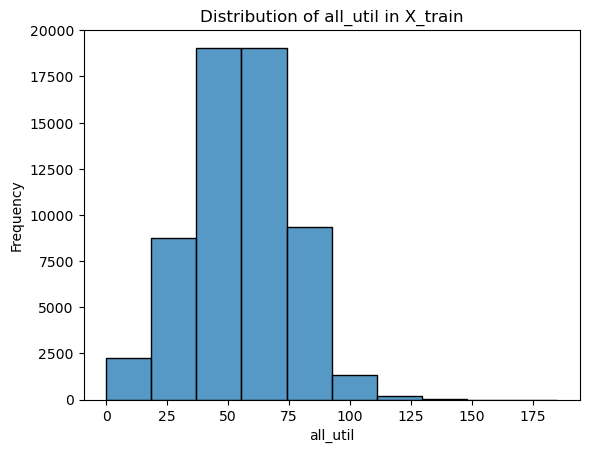

In [140]:
# Visualize distribution of all_util
sns.histplot(X_train['all_util'], bins = 10)

# Add labels and title
plt.title('Distribution of all_util in X_train')
plt.xlabel('all_util')
plt.ylabel('Frequency')

plt.show()

In [141]:
# Remove instances all_util > 100
X_train = X_train[X_train['all_util'] <= 100]

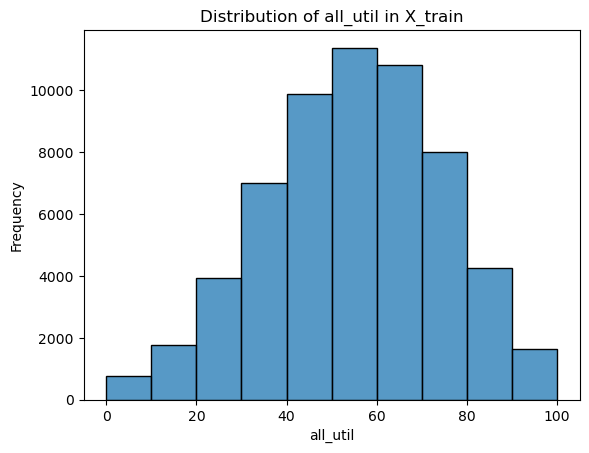

In [142]:
# Confirm that instances were removed.

# Visualize distribution of all_util
sns.histplot(X_train['all_util'], bins = 10)

# Add labels and title
plt.title('Distribution of all_util in X_train')
plt.xlabel('all_util')
plt.ylabel('Frequency')

plt.show()

#### chargeoff_within_12_mths

Most applicants have no chargeoffs in the past 12 months. Instead, it would makse sense to convert this feature to a binary that measures if the applicant had a chargeoff in the last 12 months. This should be enough signal for the model.

In [143]:
# Group by chargeoff_within_12_mths
X_train.groupby('chargeoff_within_12_mths').size()

chargeoff_within_12_mths
0    59084
1      299
2       16
3        3
4        1
6        1
dtype: int64

In [144]:
# Most applicants do not have chargeoffs on record.
# Makes sense to convert ot a binary that measures if the applicant had a chargeoff if the last 12 months.
X_train['chargeoff_within_12_mths'] = np.where(X_train['chargeoff_within_12_mths'] > 0, 1, 0)
X_test['chargeoff_within_12_mths'] = np.where(X_test['chargeoff_within_12_mths'] > 0, 1, 0)

#### collections_12_mths_ex_med

Similar case where most applicants have no chargeoffs (excluding medical) in the past 12 months. Instead, it would makse sense to convert this feature to a binary that measures if the applicant had a chargeoff in the last 12 months. This should be enough signal for the model.

In [145]:
# Group by collections_12_mths_ex_med
X_train.groupby('collections_12_mths_ex_med').size()

collections_12_mths_ex_med
0     58564
1       783
2        47
3         8
6         1
10        1
dtype: int64

In [146]:
# Most applicants do not have collections on record.
# Makes sense to convert ot a binary that measures if the applicant had a collections if the last 12 months.
X_train['collections_12_mths_ex_med'] = np.where(X_train['collections_12_mths_ex_med'] > 0, 1, 0)
X_test['collections_12_mths_ex_med'] = np.where(X_test['collections_12_mths_ex_med'] > 0, 1, 0)

#### delinq_2yrs

Most applicants do not have delinquencies on their record. Like previous the previous two features, this will be converted to binary. This should be enough signal for the model.

In [147]:
# Group by delinq_2yrs
X_train.groupby('delinq_2yrs').size()

delinq_2yrs
0     51164
1      5893
2      1361
3       508
4       216
5       107
6        59
7        37
8        23
9        12
10       10
11        6
12        3
13        2
14        1
15        1
17        1
dtype: int64

In [148]:
# Most applicants do not have delinquencies on record.
# Makes sense to convert ot a binary that measures if the applicant had a delinquencies if the last 2 years.
X_train['delinq_2yrs'] = np.where(X_train['delinq_2yrs'] > 0, 1, 0)
X_test['delinq_2yrs'] = np.where(X_test['delinq_2yrs'] > 0, 1, 0)

#### annual_inc

Annual income is skewed right some extreme values. Even when removing instances > 99th percentile, it's still skewed right. A transformation will be applied to give annual income a normal distribution.

Any instances > 99th percentile will removed and square root transformation will be applied to the data that remains.

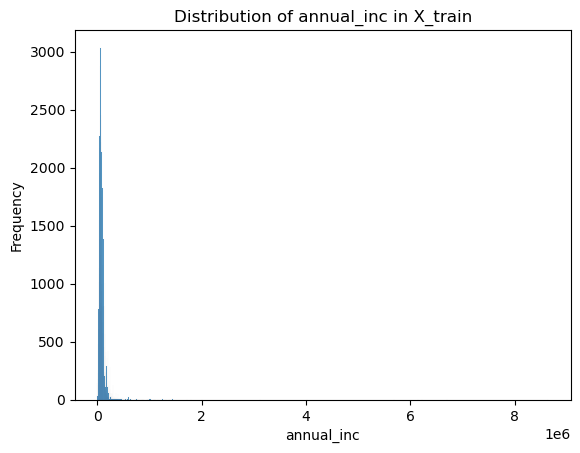

In [149]:
# Visualize distribution of annual_inc
sns.histplot(X_train['annual_inc'])

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

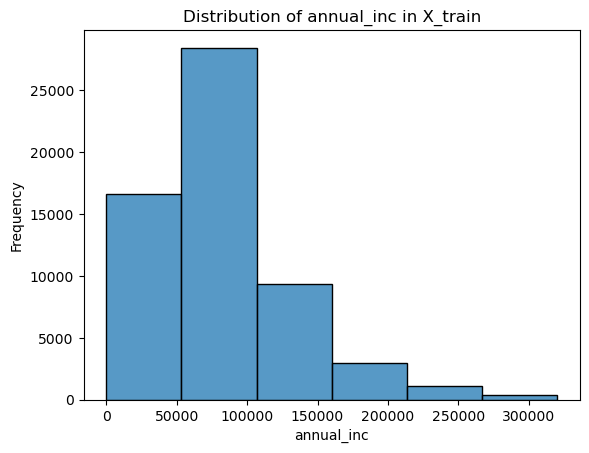

In [150]:
# Long tail. Let's zoom in to just the 99th percentile

# Visualize distribution of annual_inc
sns.histplot(X_train.loc[X_train['annual_inc'] <= X_train['annual_inc'].quantile(0.99) ,'annual_inc'], binwidth = 50000)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

In [151]:
# Looks better so let's remove the points > 99th percentile
X_train = X_train[X_train['annual_inc'] <= X_train['annual_inc'].quantile(0.99)]

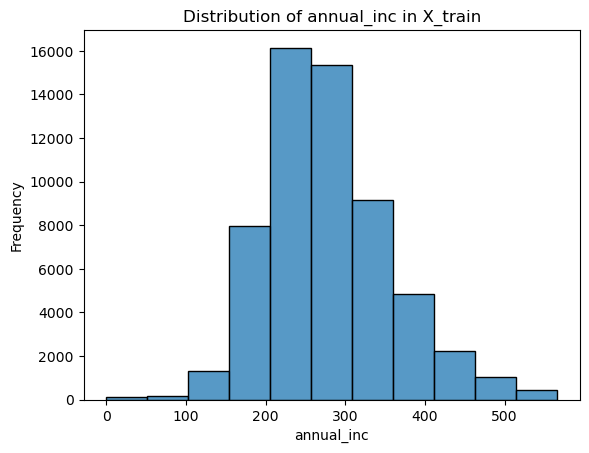

In [152]:
# Since the data is still skewed right, let's explore a square root tranformation.

# Visualize distribution of annual_inc
sns.histplot(np.sqrt(X_train['annual_inc']), binwidth=50)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

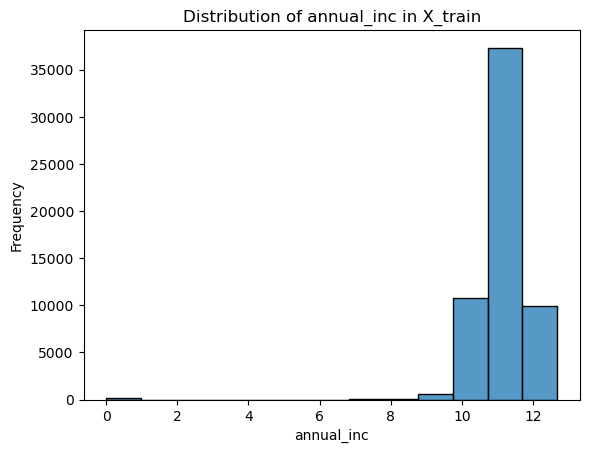

In [153]:
# Let's explore a log transformation

# Visualize distribution of annual_inc
sns.histplot(np.log(X_train['annual_inc']+1), binwidth = 1)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

In [154]:
# Apply a square root transformation to annual income
X_train['annual_inc_sqrt'] = np.sqrt(X_train['annual_inc'])
X_dev['annual_inc_sqrt'] = np.sqrt(X_dev['annual_inc'])
X_test['annual_inc_sqrt'] = np.sqrt(X_test['annual_inc'])

# Drop original columns
X_train = X_train.drop(columns = ['annual_inc'])
X_dev = X_dev.drop(columns = ['annual_inc'])
X_test = X_test.drop(columns = ['annual_inc'])

#### dti

Another case of a feature with a long tail. Even when filtering to the 99th percentile, there's still a tail at roughly 40%. As a result, data > 40% will be removed.

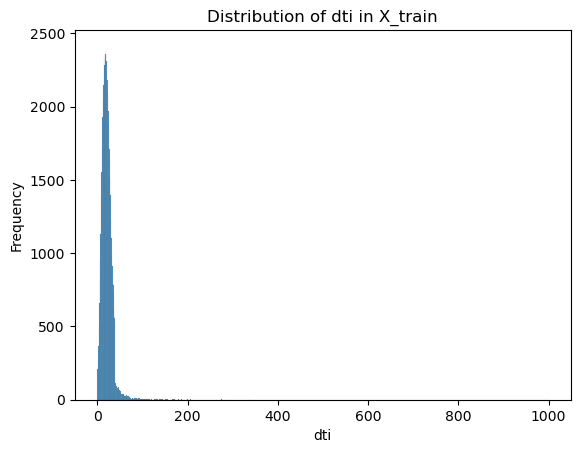

In [155]:
# Visualize distribution of all_util
sns.histplot(X_train['dti'], binwidth = 1)

# Add labels and title
plt.title('Distribution of dti in X_train')
plt.xlabel('dti')
plt.ylabel('Frequency')

plt.show()

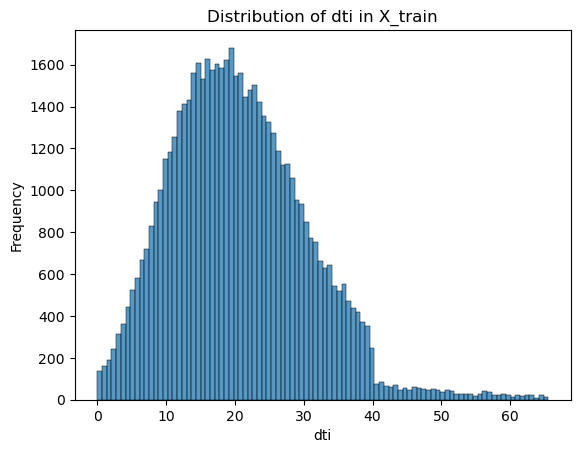

In [156]:
# Long tail. Let's zoom in to just the 99th percentile. Data drops off at ~40.

# Visualize distribution of dti
sns.histplot(X_train.loc[X_train['dti'] <= X_train['dti'].quantile(0.99) ,'dti'])

# Add labels and title
plt.title('Distribution of dti in X_train')
plt.xlabel('dti')
plt.ylabel('Frequency')

plt.show()

In [157]:
# Instances > 40 will be removed
X_train = X_train[X_train['dti'] <= 40]

#### Fico

The descriptive statistics suggest that all fico_range_low and fico_range_high scores have a range of 4. After verifying, this is true. Dropping fico_range_low since fico_range_high will suffice.

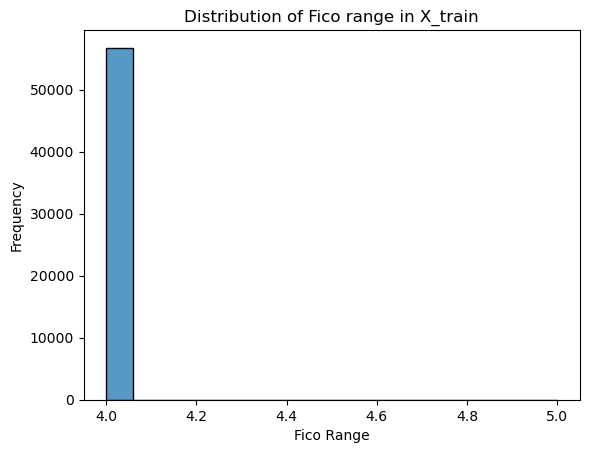

In [158]:
# Data preview suggest there's a consistent difference between the high and low score. Let's verify.
sns.histplot(X_train['fico_range_high'] - X_train['fico_range_low'])

# Add labels and title
plt.title('Distribution of Fico range in X_train')
plt.xlabel('Fico Range')
plt.ylabel('Frequency')

plt.show()

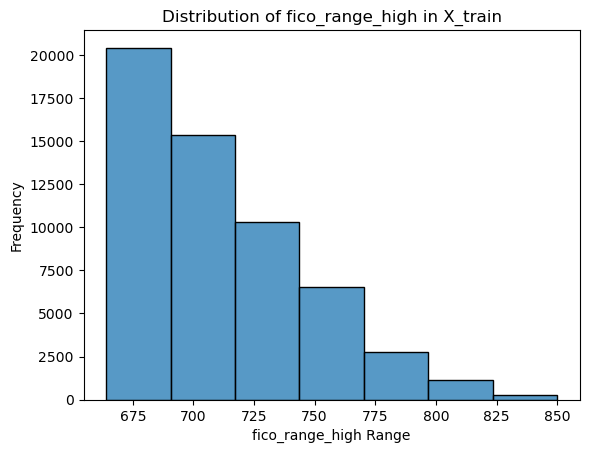

In [159]:
# Data preview suggest there's a consistent difference between the high and low score. Let's verify.
sns.histplot(X_train['fico_range_high'], binwidth = 25)

# Add labels and title
plt.title('Distribution of fico_range_high in X_train')
plt.xlabel('fico_range_high Range')
plt.ylabel('Frequency')

plt.show()

In [160]:
# It's all 4. Dropping the low column
X_train = X_train.drop(columns = ['fico_range_low'])
X_dev = X_dev.drop(columns = ['fico_range_low'])
X_test = X_test.drop(columns = ['fico_range_low'])

#### inq_last_12m

Another long tail. Removing data > the 99th percentile.

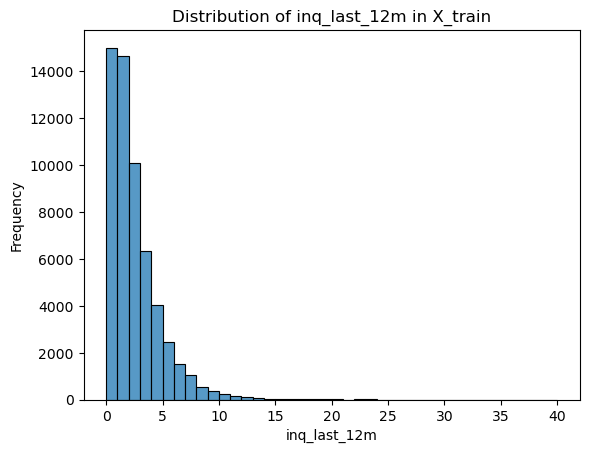

In [161]:
# Visualize distribution of inq_last_12m
sns.histplot(X_train['inq_last_12m'], binwidth = 1)

# Add labels and title
plt.title('Distribution of inq_last_12m in X_train')
plt.xlabel('inq_last_12m')
plt.ylabel('Frequency')

plt.show()

In [162]:
# 99% captured at 10.
X_train['inq_last_12m'].quantile(0.99)

10.0

In [163]:
# Remove instances where inquiries are greater than 10
X_train = X_train[X_train['inq_last_12m'] <= 10]

#### mo_sin_old_il_acct

Another long tail. Removing instances that are greater than the 99th percentile.

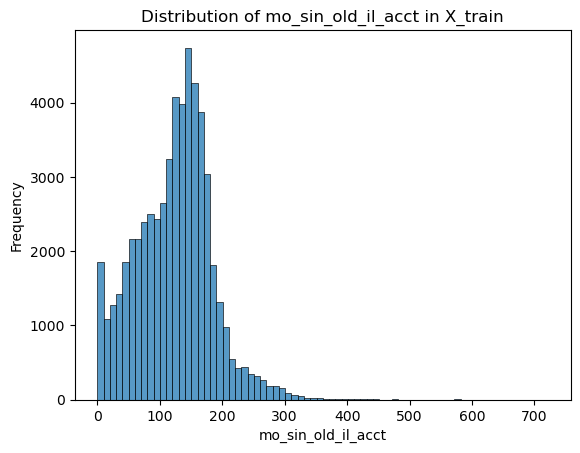

In [164]:
# Visualize distribution of mo_sin_old_il_acct
sns.histplot(X_train['mo_sin_old_il_acct'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_il_acct in X_train')
plt.xlabel('mo_sin_old_il_acct')
plt.ylabel('Frequency')

plt.show()

In [165]:
# 99% captured at 287.
X_train['mo_sin_old_il_acct'].quantile(0.99)

287.0

In [166]:
# Remove instances where inquiries are greater than 287
X_train = X_train[X_train['mo_sin_old_il_acct'] <= 287]

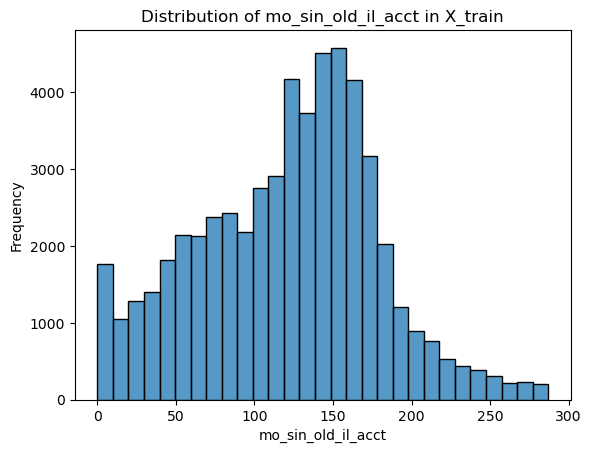

In [167]:
# Visualize distribution of mo_sin_old_il_acct
sns.histplot(X_train['mo_sin_old_il_acct'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_il_acct in X_train')
plt.xlabel('mo_sin_old_il_acct')
plt.ylabel('Frequency')

plt.show()

#### mo_sin_old_rev_tl_op

Another long tail. Removing instances > than the 99th percentile.

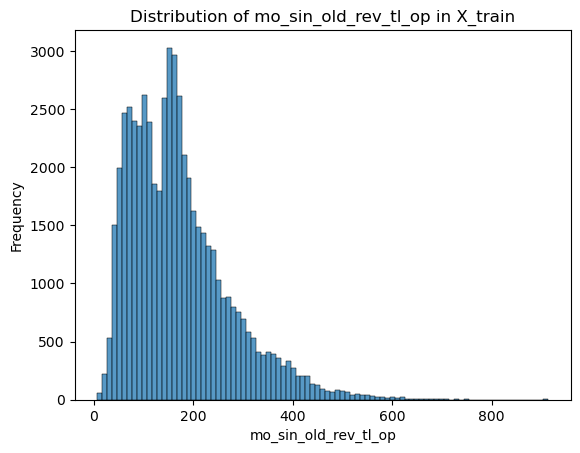

In [168]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mo_sin_old_rev_tl_op'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_rev_tl_op in X_train')
plt.xlabel('mo_sin_old_rev_tl_op')
plt.ylabel('Frequency')

plt.show()

In [169]:
# 99% captured at 287.
X_train['mo_sin_old_rev_tl_op'].quantile(0.99)

486.8799999999974

In [170]:
# Remove instances where inquiries are greater than 287
X_train = X_train[X_train['mo_sin_old_rev_tl_op'] <= 485]

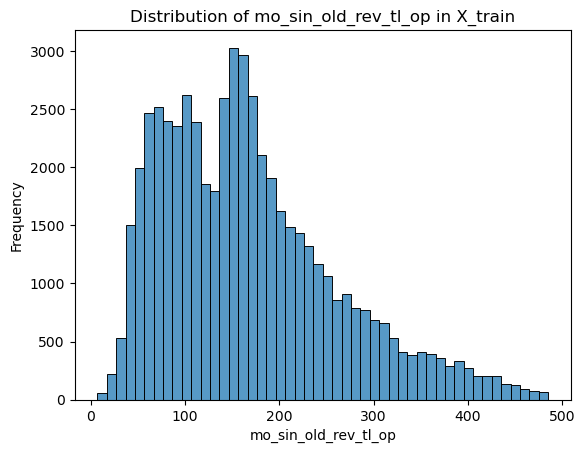

In [171]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mo_sin_old_rev_tl_op'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_rev_tl_op in X_train')
plt.xlabel('mo_sin_old_rev_tl_op')
plt.ylabel('Frequency')

plt.show()

#### mort_acc

Another long tail. Removing instances greater than the 99th percentile. Also, many applicants don't have a mortgage account. Adding a binary column to identify those who do and do not assist with training.

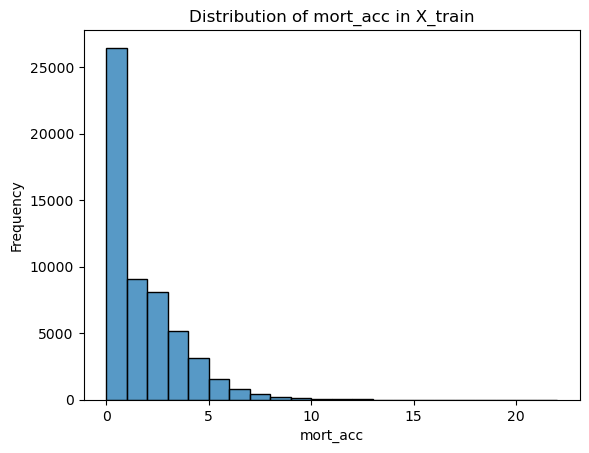

In [172]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mort_acc'], binwidth = 1)

# Add labels and title
plt.title('Distribution of mort_acc in X_train')
plt.xlabel('mort_acc')
plt.ylabel('Frequency')

plt.show()

In [173]:
# 99% captured at 7.
X_train['mort_acc'].quantile(0.99)

7.0

In [174]:
# Remove instances > 7
X_train = X_train[X_train['mort_acc'] <= 7]

# Add a binary column that evaluates if the applicant had mortgage account.
X_train['has_mort_acc'] = np.where(X_train['mort_acc'] > 0, 1, 0)
X_dev['has_mort_acc'] = np.where(X_dev['mort_acc'] > 0, 1, 0)
X_test['has_mort_acc'] = np.where(X_test['mort_acc'] > 0, 1, 0)

#### mths_since_recent_inq

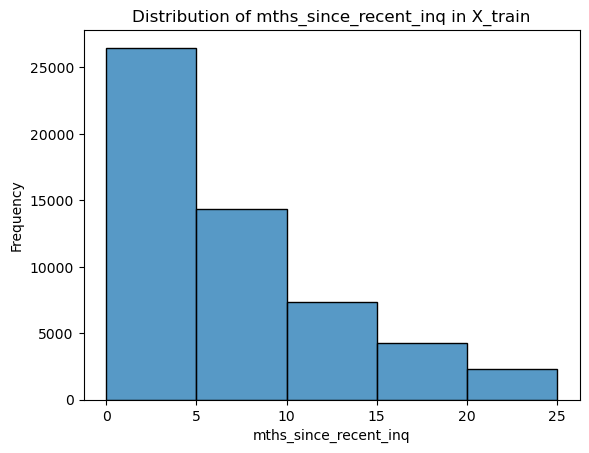

In [175]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mths_since_recent_inq'], binwidth = 5)

# Add labels and title
plt.title('Distribution of mths_since_recent_inq in X_train')
plt.xlabel('mths_since_recent_inq')
plt.ylabel('Frequency')

plt.show()

#### pub_rec_bankruptcies

Many applicants do not have bankruptcies on their record. Converting to a binary that measures whether or not the applicant had one. 

In [176]:
# Group by chargeoff_within_12_mths
X_train.groupby('pub_rec_bankruptcies').size()

pub_rec_bankruptcies
0    49780
1     4908
2       58
3        5
4        3
7        1
dtype: int64

In [177]:
# Most applicants do not have bankruptcies on record.
# Makes sense to convert ot a binary that measures if the applicant had a bankruptcy.
X_train['pub_rec_bankruptcies'] = np.where(X_train['pub_rec_bankruptcies'] > 0, 1, 0)
X_dev['pub_rec_bankruptcies'] = np.where(X_dev['pub_rec_bankruptcies'] > 0, 1, 0)
X_test['pub_rec_bankruptcies'] = np.where(X_test['pub_rec_bankruptcies'] > 0, 1, 0)

#### total_bal_ex_mort

Long tail. Removing instances greater than the 99th percentile. Also added a square root transformation to to give it a normal distribution.

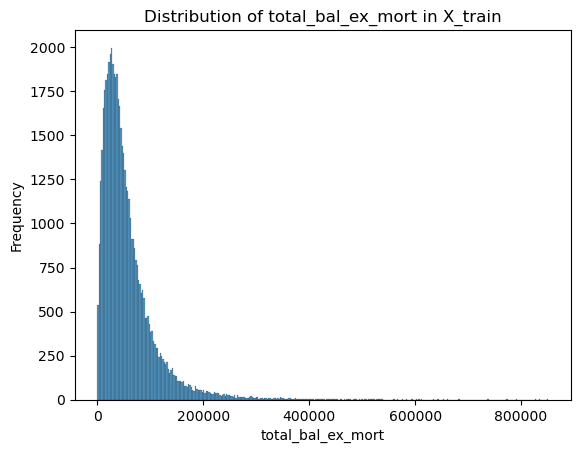

In [178]:
# Visualize distribution of total_bal_ex_mort
sns.histplot(X_train['total_bal_ex_mort'])

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

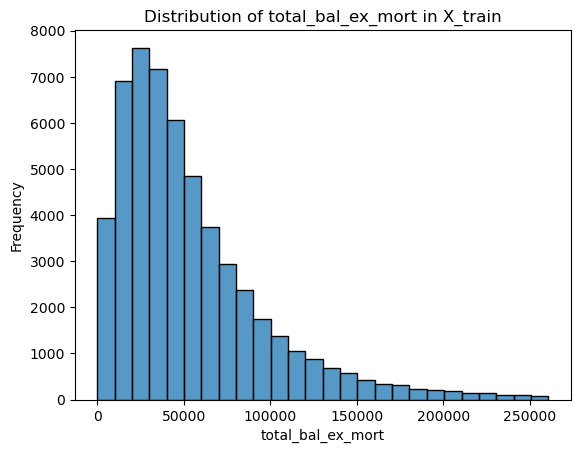

In [179]:
# Long tail. Let's zoom in to just the 99th percentile

# Visualize distribution of annual_inc
sns.histplot(X_train.loc[X_train['total_bal_ex_mort'] <= X_train['total_bal_ex_mort'].quantile(0.99) ,'total_bal_ex_mort'], binwidth = 10000)

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

In [180]:
# Looks better so let's remove the points > 99th percentile
X_train = X_train[X_train['total_bal_ex_mort'] <= X_train['total_bal_ex_mort'].quantile(0.99)]

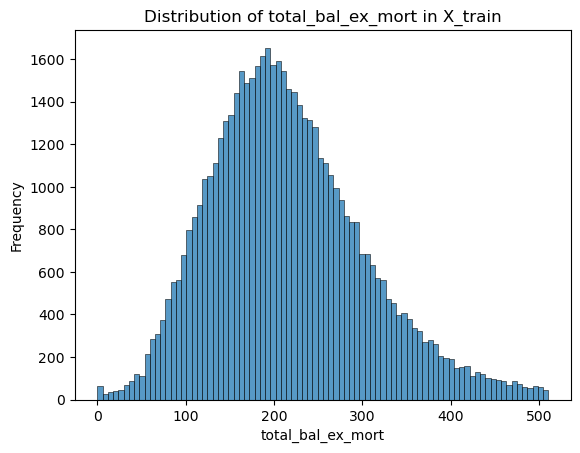

In [181]:
# Since the data is still skewed right, let's explore a square root tranformation.

# Visualize distribution of total_bal_ex_mort
sns.histplot(np.sqrt(X_train['total_bal_ex_mort']))

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

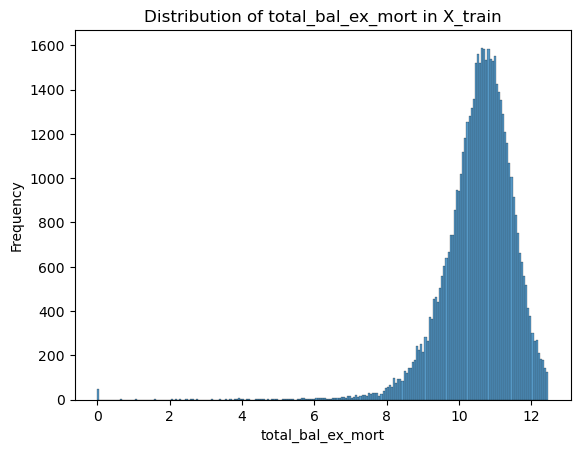

In [182]:
# Since the data is still skewed right, let's explore a log tranformation.

# Visualize distribution of total_bal_ex_mort
sns.histplot(np.log(X_train['total_bal_ex_mort']+1))

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

In [183]:
# Apply a square root transformation to annual income
X_train['total_bal_ex_mort_sqrt'] = np.sqrt(X_train['total_bal_ex_mort'])
X_dev['total_bal_ex_mort_sqrt'] = np.sqrt(X_dev['total_bal_ex_mort'])
X_test['total_bal_ex_mort_sqrt'] = np.sqrt(X_test['total_bal_ex_mort'])

# Drop original columns
X_train = X_train.drop(columns = ['total_bal_ex_mort'])
X_dev = X_dev.drop(columns = ['total_bal_ex_mort'])
X_test = X_test.drop(columns = ['total_bal_ex_mort'])

****

## Data Exploration

In [184]:
# Create df using training set for EDA
df_eda = X_train.copy()

### Pair Plot

The pair plot is a good starting point to visualize the data and see any initial initial relationships. Using only the numeric columns, we can see that there aren't any linear relationships between the dependent variable and independent variables. However, there are signs of linear relationships between independent variables.

In [185]:
# Define columns for numeric pair plot
num_cols = ['all_util', 
            'dti', 
            'fico_range_high', 
            'inq_last_12m', 
            'loan_amnt', 
            'mo_sin_old_il_acct', 
            'mo_sin_old_rev_tl_op', 
            'mort_acc', 
            'mths_since_recent_inq', 
            'emp_length_num',
            'annual_inc_sqrt',
            'total_bal_ex_mort_sqrt',
            'int_rate']

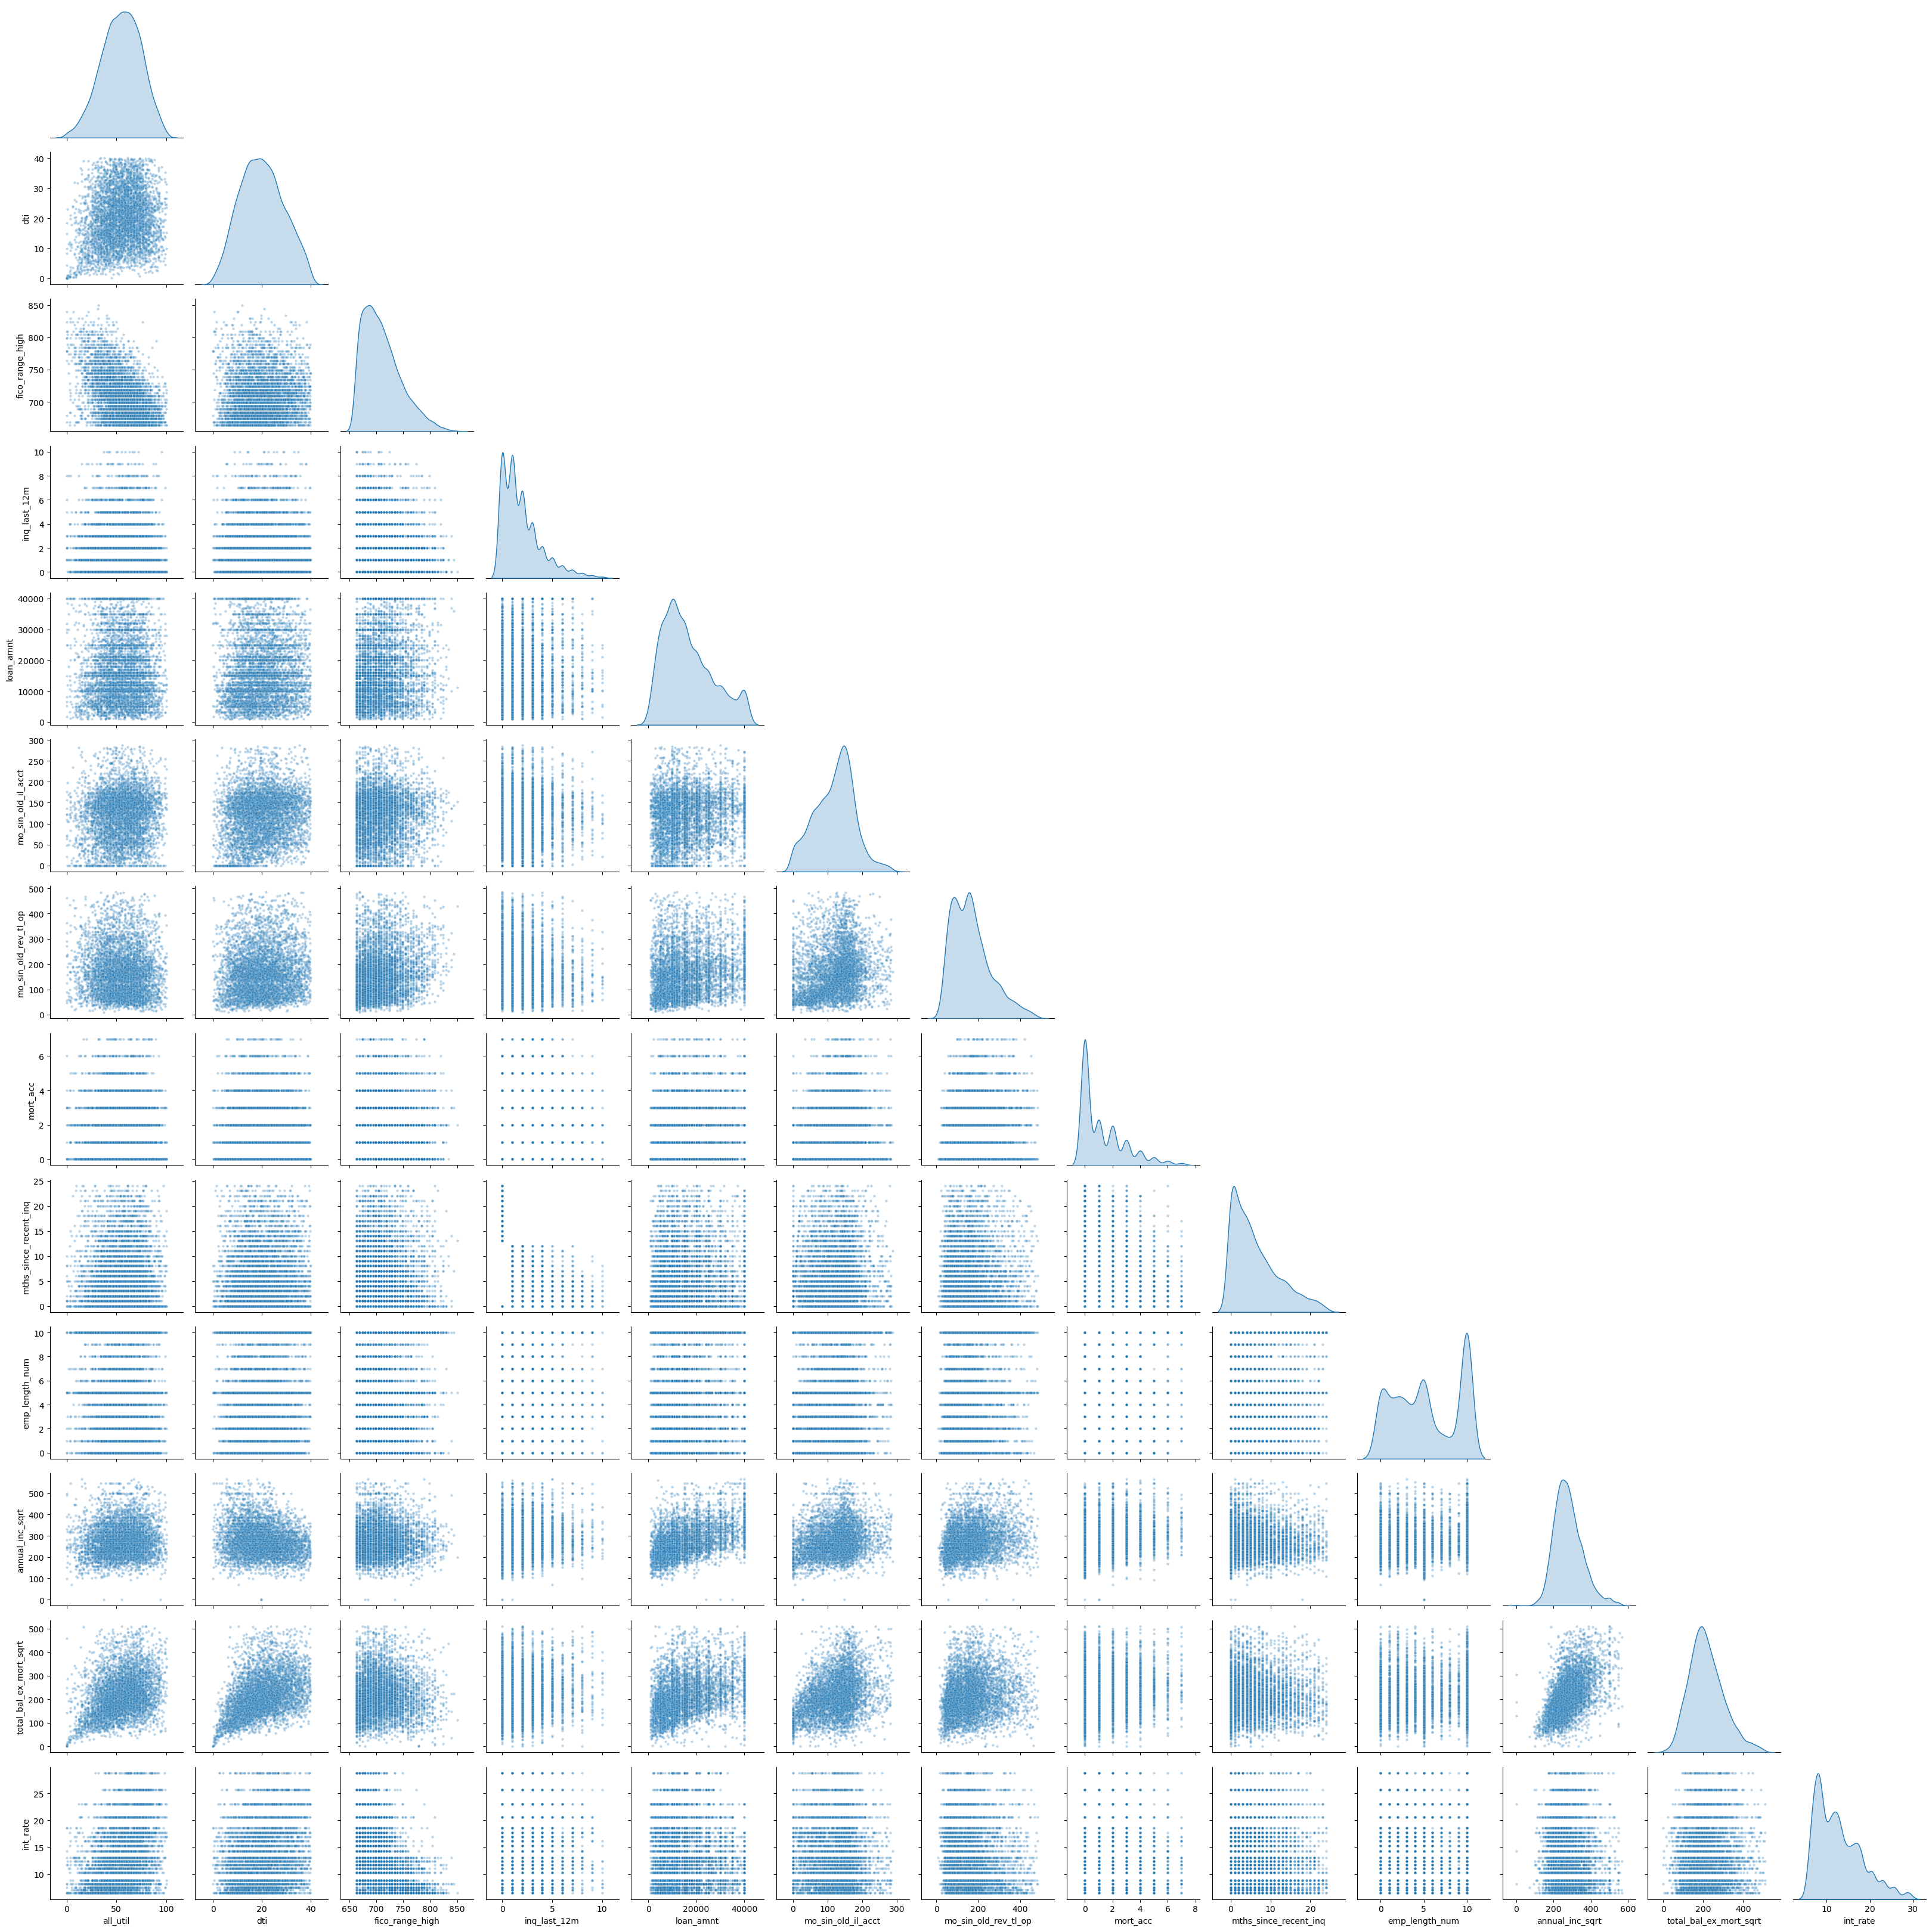

In [186]:
# Create pair plot
sns.pairplot(
    df_eda[num_cols].sample(n = 5000, random_state = 206), # Reducing sample size to help with processing time
    vars = num_cols,
    diag_kind = "kde",
    corner = True,
    plot_kws = dict(alpha = 0.3, s = 10)
)

plt.tight_layout()
plt.show()

### Correlation Analysis

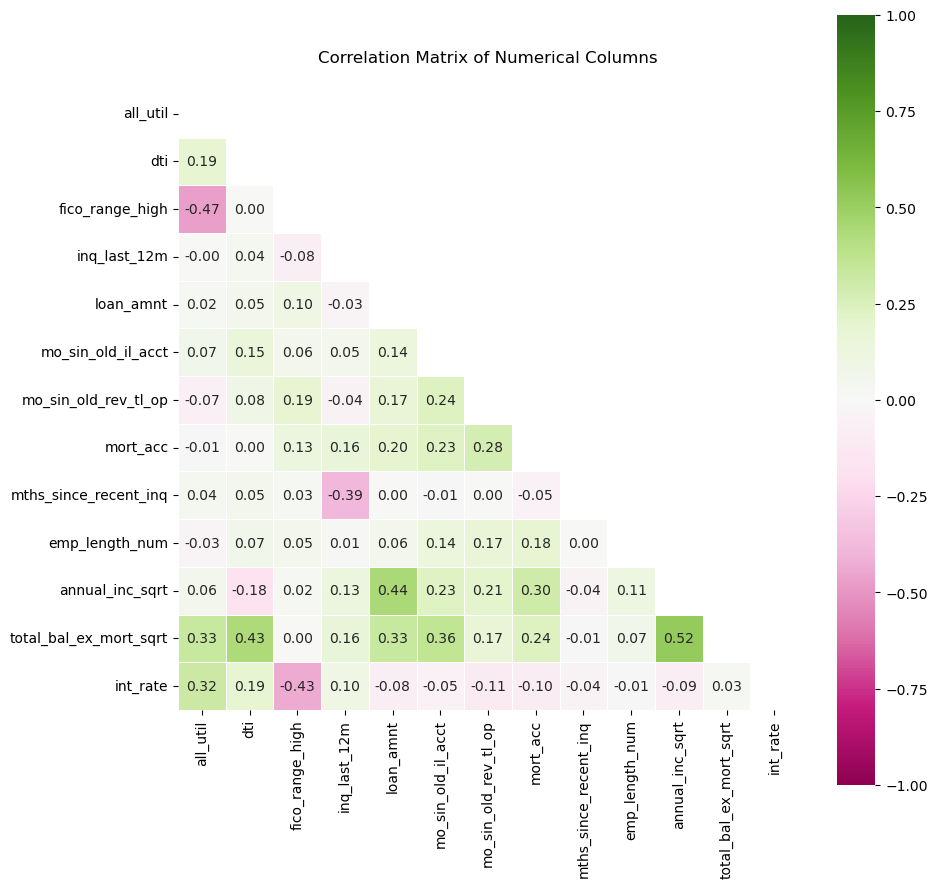

In [187]:
# Calculate correlation
corr = df_eda[num_cols].corr().round(2)

# Visualize
plt.figure(figsize = (10, 10))
sns.heatmap(
    corr,
    mask = np.triu(np.ones_like(corr, dtype = bool)),
    annot = True,
    fmt = "0.2f",
    cmap = "PiYG",
    vmin = -1, vmax = 1,
    linewidths = 0.5,
    square = True
)


plt.title("Correlation Matrix of Numerical Columns", pad = 20)
plt.show()

#### int_rate

Based on r scores, all_util and fico_range_high suggest moderate correlation to interest rate.
* all_util (r = 0.32): As all_util increases, interest rate increases.
* fico_range_high (r = -0.43): As fico_range_high increases, interest rate decreases.

However, when visualizing both, there isn't a clear linear relationship with interest rate.

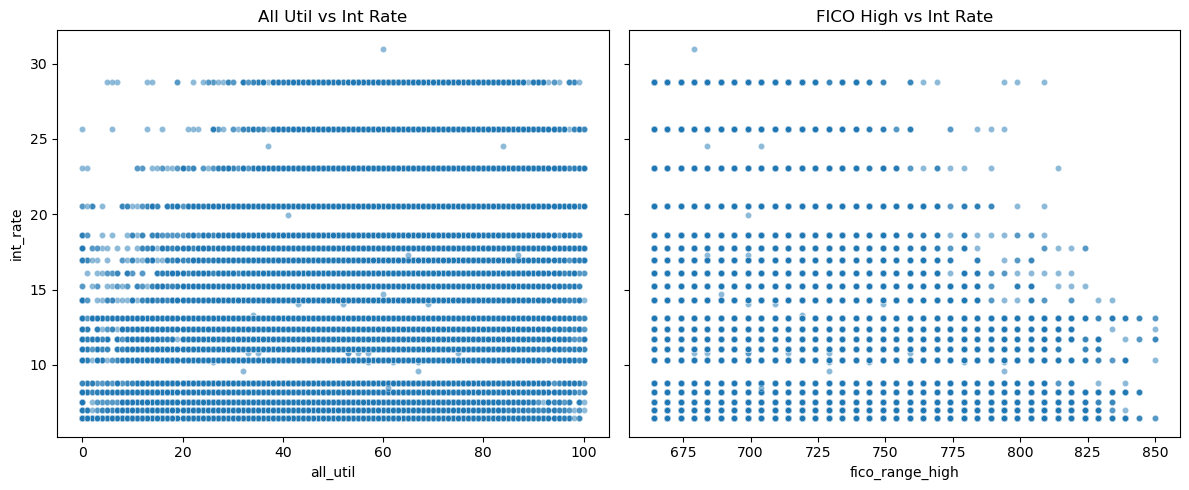

In [188]:
# create a figure with 1 row, 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

# first scatter on the left
sns.scatterplot(
    data=df_eda,
    x="all_util",
    y="int_rate",
    ax=axes[0],
    alpha=0.5,
    s=20
)
axes[0].set_title("All Util vs Int Rate")

# second scatter on the right
sns.scatterplot(
    data=df_eda,
    x="fico_range_high",
    y="int_rate",
    ax=axes[1],
    alpha=0.5,
    s=20
)
axes[1].set_title("FICO High vs Int Rate")

plt.tight_layout()
plt.show()


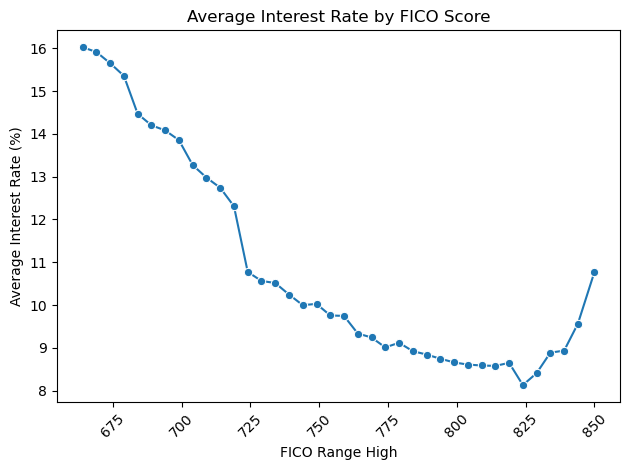

In [189]:
# Visualize relationship between FICO and Interest rate

# Create subset
fico_df = (
    df_eda
    .groupby('fico_range_high', as_index=False)['int_rate']
    .mean()
    .rename(columns={'int_rate': 'avg_int_rate'})
)

# Plot with a line plot
sns.lineplot(
    data=fico_df,
    x='fico_range_high',
    y='avg_int_rate',
    marker='o'
)
plt.title('Average Interest Rate by FICO Score')
plt.xlabel('FICO Range High')
plt.ylabel('Average Interest Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [190]:
# Unusual phenomenon where interest rates start to increase when Fico is greater than 825. Tied to limited instances of applicants with Fico scores greater than 825. 
# Records with Fico scores greater than 825 will be removed.
X_train = X_train[X_train['fico_range_high'] <= 825]

#### all_util vs fico_range_high

The features moderate and correlation (r = -0.47). Given that all_util is used to determine fico scores, we will drop all_util.

In [191]:
# Drop all_util from train, dev, and test sets
X_train = X_train.drop(columns = 'all_util')
X_dev = X_dev.drop(columns = 'all_util')
X_test = X_test.drop(columns = 'all_util')

#### total_bal_ex_mort_sqrt

Feature appears to have moderate correlation to multiple variables. Pair plot and heat map suggest correlation with multiple variables. To help with processing, we'll drop the feature.

In [192]:
# Drop total_bal_ex_mort_sqrt from train, dev, and test sets
X_train = X_train.drop(columns = 'total_bal_ex_mort_sqrt')
X_dev = X_dev.drop(columns = 'total_bal_ex_mort_sqrt')
X_test = X_test.drop(columns = 'total_bal_ex_mort_sqrt')

#### inq_last_12m vs mths_since_recent_inq

Features have a moderate and negative correlation (r = -0.39). Both are related to inquiries, so we'll drop one feature. In this case, we'll keep inq_last_12m.

In [193]:
# Drop total_bal_ex_mort_sqrt from train, dev, and test sets
X_train = X_train.drop(columns = 'mths_since_recent_inq')
X_dev = X_dev.drop(columns = 'mths_since_recent_inq')
X_test = X_test.drop(columns = 'mths_since_recent_inq')

### Dummy Variable Analysis

#### chargeoff_within_12_mths

Interest rates are generally higher if an applicant had a charge off in the last 12 months.

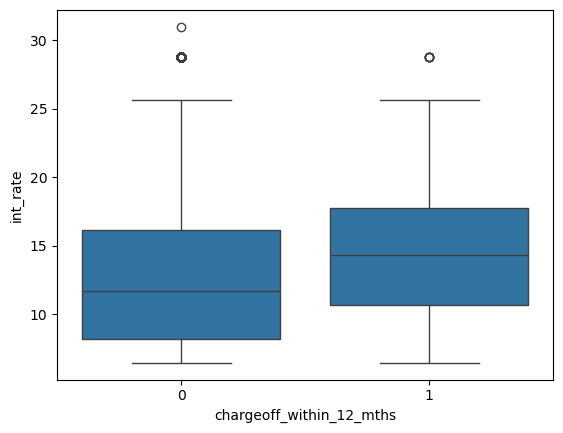

In [194]:
# Visualize
sns.boxplot(df_eda,
            x = 'chargeoff_within_12_mths',
            y = 'int_rate')

plt.show()

In [195]:
# Run stats of chargeoff_within_12_mths

stats_chargeoff = (
    df_eda
    .groupby('chargeoff_within_12_mths')['int_rate']
    .agg(
        min='min',
        q1=lambda x: x.quantile(0.25),
        med='median',
        q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean'
    )
    .rename(columns={'q1':'25%','med':'50%','q3':'75%'})
)

print(stats_chargeoff)


                           min     25%    50%    75%    max       mean
chargeoff_within_12_mths                                              
0                         6.46   8.190  11.71  16.12  30.99  12.875512
1                         6.46  10.675  14.30  17.74  28.80  14.442575


#### collections_12_mths_ex_med

Applications that have had collections (exluding medical) in the last 12 months generally have higher interest rates.

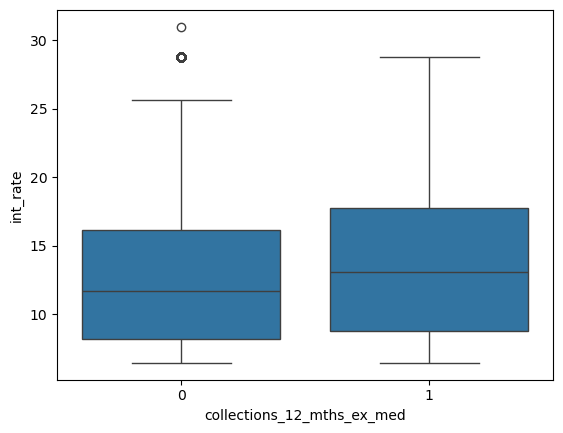

In [196]:
# Visualize
sns.boxplot(df_eda,
            x = 'collections_12_mths_ex_med',
            y = 'int_rate')

plt.show()

In [197]:
# Run stats of collections_12_mths_ex_med

stats_collections_ex_med = (
    df_eda
    .groupby('collections_12_mths_ex_med')['int_rate']
    .agg(
        min='min',
        q1=lambda x: x.quantile(0.25),
        med='median',
        q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean'
    )
    .rename(columns={'q1':'25%','med':'50%','q3':'75%'})
)

print(stats_collections_ex_med)

                             min   25%    50%    75%    max       mean
collections_12_mths_ex_med                                            
0                           6.46  8.19  11.71  16.12  30.99  12.866522
1                           6.46  8.81  13.08  17.74  28.80  14.079530


#### delinq_2yrs

Applicants that have had any 30+ days past-due incidences of delinquency generally have higher interest rates.

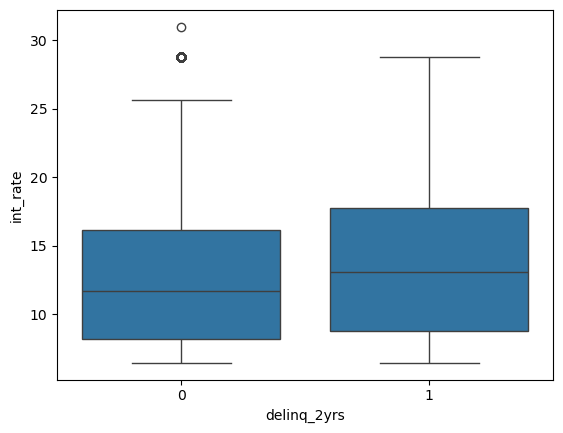

In [198]:
# Visualize
sns.boxplot(df_eda,
            x = 'delinq_2yrs',
            y = 'int_rate')

plt.show()

In [199]:
# Run stats of delinq_2yrs

stats_delinq_2yrs = (
    df_eda
    .groupby('delinq_2yrs')['int_rate']
    .agg(
        min='min',
        q1=lambda x: x.quantile(0.25),
        med='median',
        q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean'
    )
    .rename(columns={'q1':'25%','med':'50%','q3':'75%'})
)

print(stats_delinq_2yrs)

              min   25%    50%    75%    max       mean
delinq_2yrs                                            
0            6.46  8.19  11.71  16.12  30.99  12.688056
1            6.46  8.81  13.08  17.74  28.80  14.117779


#### pub_rec_bankruptcies

Applicants with bankruptcies on their record generally have higher interest rates.

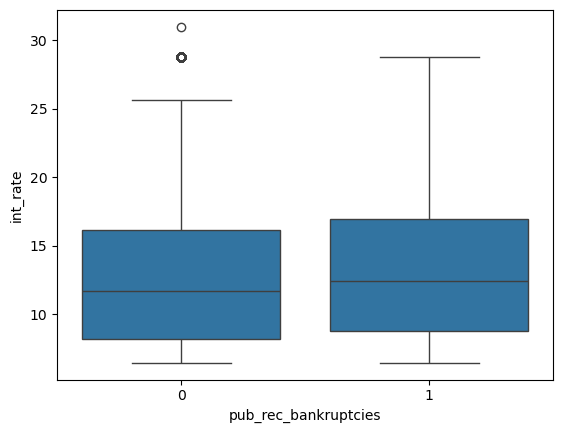

In [200]:
# Visualize
sns.boxplot(df_eda,
            x = 'pub_rec_bankruptcies',
            y = 'int_rate')

plt.show()

In [201]:
# Run stats

stats_pub_rec_bankruptcies = (
    df_eda
    .groupby('pub_rec_bankruptcies')['int_rate']
    .agg(
        min='min',
        q1=lambda x: x.quantile(0.25),
        med='median',
        q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean'
    )
    .rename(columns={'q1':'25%','med':'50%','q3':'75%'})
)

print(stats_pub_rec_bankruptcies)

                       min   25%    50%    75%    max       mean
pub_rec_bankruptcies                                            
0                     6.46  8.19  11.71  16.12  30.99  12.833362
1                     6.46  8.81  12.40  16.95  28.80  13.389822


#### application_type

Joint Applicants generally have higher interest rates than individual applications.

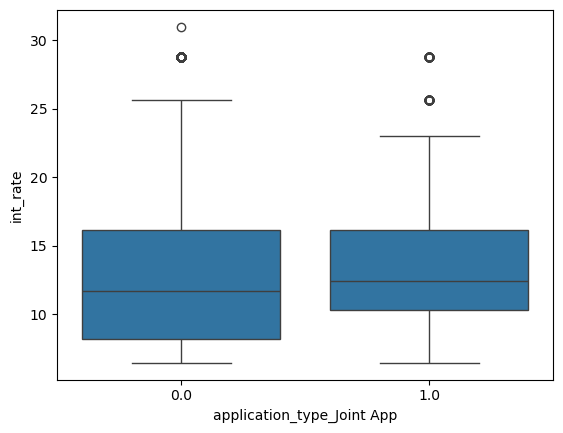

In [202]:
# Visualize
sns.boxplot(df_eda,
            x = 'application_type_Joint App',
            y = 'int_rate')

plt.show()

In [203]:
# Run stats

stats_application_type = (
    df_eda
    .groupby('application_type_Joint App')['int_rate']
    .agg(
        min='min',
        q1=lambda x: x.quantile(0.25),
        med='median',
        q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean'
    )
    .rename(columns={'q1':'25%','med':'50%','q3':'75%'})
)

print(stats_application_type)

                             min    25%    50%    75%    max       mean
application_type_Joint App                                             
0.0                         6.46   8.19  11.71  16.12  30.99  12.839145
1.0                         6.46  10.33  12.40  16.12  28.80  13.303090


#### term

Applicants generally have higher interest rates when taking 60-month terms vs 36-month terms.

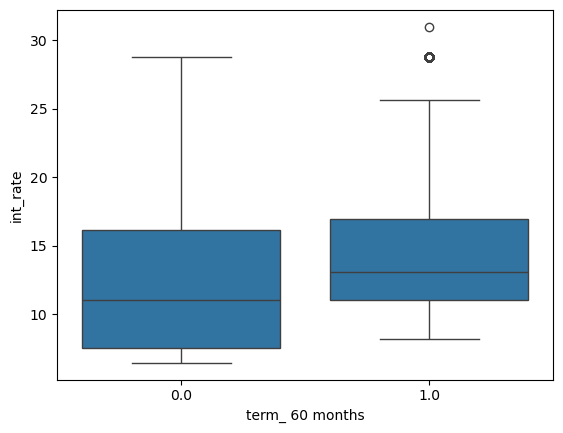

In [204]:
# Visualize
sns.boxplot(df_eda,
            x = 'term_ 60 months',
            y = 'int_rate')

plt.show()

In [205]:
# Run stats

stats_term = (
    df_eda
    .groupby('term_ 60 months')['int_rate']
    .agg(
        min='min',
        q1=lambda x: x.quantile(0.25),
        med='median',
        q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean'
    )
    .rename(columns={'q1':'25%','med':'50%','q3':'75%'})
)

print(stats_term)

                  min    25%    50%    75%    max       mean
term_ 60 months                                             
0.0              6.46   7.56  11.02  16.12  28.80  12.256678
1.0              8.19  11.02  13.08  16.95  30.99  14.101137


****

## Feature Engineering

### Min/Max Normalization

Normalizing the data assists the neural network model.

In [206]:
#Scaling data to the range of 0 to 1 using min/max normalization
scaler = MinMaxScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_dev_s = scaler.transform(X_dev)
X_test_s = scaler.transform(X_test)

# Wrap back into Dataframes with column names
X_train_s = pd.DataFrame(X_train_s,
                         index=X_train.index,
                         columns=X_train.columns)
X_dev_s   = pd.DataFrame(X_dev_s,
                         index=X_dev.index,
                         columns=X_dev.columns)
X_test_s  = pd.DataFrame(X_test_s,
                         index=X_test.index,
                         columns=X_test.columns)

****

## Split X & Y variables

In [207]:
# Pull out the target variable
y_train = X_train['int_rate'].copy()
y_dev = X_dev['int_rate'].copy()
y_test = X_test['int_rate'].copy()

y_train_s = X_train_s['int_rate'].copy()
y_dev_s = X_dev_s['int_rate'].copy()
y_test_s = X_test_s['int_rate'].copy()

# Drop from target variable from X set
X_train = X_train.drop(columns = ['int_rate'])
X_dev = X_dev.drop(columns = ['int_rate'])
X_test = X_test.drop(columns = ['int_rate'])

X_train_s = X_train_s.drop(columns = ['int_rate'])
X_dev_s = X_dev_s.drop(columns = ['int_rate'])
X_test_s = X_test_s.drop(columns = ['int_rate'])

****

## Model Fitting

### Random Forest

In [208]:
# Creating a subset for training

# Stratify on binned int_rate to keep target distribution
bins = pd.qcut(y_train, q=5, labels=False)

X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=0.20,         
    stratify=bins,
    random_state=206
)

In [209]:
#Initialize and fit to the training data
rf_regressor = RandomForestRegressor(random_state = 206,
                                     n_jobs = -1)

In [210]:
# Define hyper‐parameter distributions
param_dist = {'max_features': range(1,9),
              'n_estimators': range(50,1000)}

# Set up RandomizedSearchCV
rand_search_rf1 = RandomizedSearchCV(
    estimator = rf_regressor,
    param_distributions = param_dist,
    n_iter=50,                       
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs = -1,                            
    random_state = 206,
    verbose = False
)

# Fit on your training data
rand_search_rf1.fit(X_sub, y_sub)

# Examine the best configuration
print("Best RF params:",   rand_search_rf1.best_params_)
print("Best CV RMSE: ",    -rand_search_rf1.best_score_)


Best RF params: {'n_estimators': 952, 'max_features': 7}
Best CV RMSE:  4.255097415480955


In [211]:
# Additional tuning
param_dist = {
    
    "n_estimators":    randint(200, 1000),    # focus on 200–1 000 now that you’ve seen 967 works
    "max_features":    randint(3, 8),         

    # ─── parameters ───
    "max_depth":       [None, 10, 20, 30],    # cap tree height
    "min_samples_split": randint(2, 10),      # require >1 sample to split
    "min_samples_leaf":  randint(1, 5),       # force leaves to have a handful of samples
    "bootstrap":       [True, False],         # with or without sampling
    "max_samples":     uniform(0.5, 0.5),     # if bootstrap, how much of the data per tree
}

rand_search_rf2 = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=50,               
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=206,
    verbose = False
)
rand_search_rf2.fit(X_sub, y_sub)

print("Best params:", rand_search_rf2.best_params_)
print("Best CV RMSE:", -rand_search_rf2.best_score_)

c:\Users\Mike\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mike\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mike\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mike\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 431, in fit
    raise ValueError(


Best params: {'bootstrap': True, 'max_depth': None, 'max_features': 7, 'max_samples': 0.9627039240575318, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 893}
Best CV RMSE: 4.245656385378891


In [212]:
# Not much improvement when adding additional parameters. Sticking with the original randomized search.
# Obtain and save the values of the best set of hyperparameters
rf_model = rand_search_rf1.best_estimator_

In [213]:
# Function to calculate metrics
def regression_metrics(y_true, y_pred):
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
    mae  = round(mean_absolute_error(y_true, y_pred),2)
    r2   = round(r2_score(y_true, y_pred),2)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

In [214]:
# Get preditions against the full training set and dev set
y_train_pred = rf_model.predict(X_train)
y_dev_pred = rf_model.predict(X_dev)

print(f"Training set metrics: {regression_metrics(y_train, y_train_pred)}")
print(f"Dev set metrics: {regression_metrics(y_dev, y_dev_pred)}")

Training set metrics: {'RMSE': 3.9, 'MAE': 2.86, 'R2': 0.45}
Dev set metrics: {'RMSE': 4.36, 'MAE': 3.32, 'R2': 0.32}


### Artificial Neural Network

In [215]:
# Creating a subset for training

# Stratify on binned int_rate to keep target distribution
bins = pd.qcut(y_train_s, q=5, labels=False)

Xs_sub, _, ys_sub, _ = train_test_split(
    X_train_s, y_train_s,
    train_size=0.20,         
    stratify=bins,
    random_state=206
)

In [216]:
#Initialize and fit to the training data
mlp_regressor = MLPRegressor(max_iter = 500,
                             random_state = 206)

In [217]:
# Define parameters for grid search
param_dist = {
    'hidden_layer_sizes': [(10,10), (10,10,10)],
    'max_iter':           [1500],                     
    'activation':         ['tanh', 'relu'],
    'solver':             ['sgd', 'adam'],
    'alpha':              uniform(1e-4, 0.1),         
    'learning_rate_init': uniform(1e-3, 0.05),        
}

# Set up the RandomizedSearchCV
rand_search_mlp1 = RandomizedSearchCV(
    estimator = mlp_regressor,
    param_distributions = param_dist,
    n_iter = 50,                          
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=206,
    n_jobs= -1,
    verbose = False
)

# Fit the grid search object to the data
rand_search_mlp1.fit(Xs_sub, ys_sub)

# Isolate the min & max that was used in the scaler
y_min = y_train.min()
y_max = y_train.max()

# Examine the best configuration
print("Best RF params:",   rand_search_mlp1.best_params_)
print("Best CV RMSE: ",    -rand_search_mlp1.best_score_ * (y_max - y_min))

Best RF params: {'activation': 'relu', 'alpha': 0.011905884811447087, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate_init': 0.004521690907318853, 'max_iter': 1500, 'solver': 'adam'}
Best CV RMSE:  4.285936051552168


In [218]:
# Refine search by trying wider and deeper nets
hidden_layer_sizes = [
    (10,), (20,10), (50,), (50,25),    # single- and two-layer variants
    (100,), (100,50), (50,50,25), (150,)       # deeper nets
]

# we saw best alpha 0.08, learning rate 0.004
param_dist = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation':        ['relu','tanh'],      # keep both
    'solver':            ['adam'],             # adam was best—drop sgd to save time
    'alpha':             uniform(0.01, 0.2),   # sample [0.01 … 0.21)
    'learning_rate_init':uniform(0.001, 0.01),  # sample [0.001 … 0.011)
    
    # new hyper-dynamics
    'learning_rate':     ['constant','adaptive'],
    'batch_size':        [32, 64, 128],
    'early_stopping':    [True],
    'validation_fraction':[0.1, 0.2],
    'n_iter_no_change':  [10, 20],
    
    # keep max_iter high so it can converge
    'max_iter':          [1500],
}

# Set up the RandomizedSearchCV
rand_search_mlp2 = RandomizedSearchCV(
    estimator = mlp_regressor,
    param_distributions = param_dist,
    n_iter = 50,                          
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=206,
    n_jobs= -1,
    verbose = False
)

# Fit the grid search object to the data
rand_search_mlp2.fit(Xs_sub, ys_sub)

# Examine the best configuration
print("Best RF params:",   rand_search_mlp2.best_params_)
print("Best CV RMSE: ",    -rand_search_mlp2.best_score_ * (y_max - y_min))

Best RF params: {'activation': 'relu', 'alpha': 0.022792212249358137, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (150,), 'learning_rate': 'constant', 'learning_rate_init': 0.0038986362957024925, 'max_iter': 1500, 'n_iter_no_change': 20, 'solver': 'adam', 'validation_fraction': 0.2}
Best CV RMSE:  4.290065576422512


In [219]:
# Wider and deeper nets didn't result in much improvement. Opting for the simpler model
# Obtain and save the values of the best set of hyperparameters
mlp_model = rand_search_mlp1.best_estimator_

In [220]:
# Get preditions against the full training set and dev set
y_train_s_pred = mlp_model.predict(X_train_s)
y_dev_s_pred = mlp_model.predict(X_dev_s)

# De-normalize
y_train_s_pred = y_train_s_pred * (y_max - y_min) + y_min
y_dev_s_pred = y_dev_s_pred * (y_max - y_min) + y_min

print(f"Training set metrics: {regression_metrics(y_train, y_train_s_pred)}")
print(f"Dev set metrics: {regression_metrics(y_dev, y_dev_s_pred)}")

Training set metrics: {'RMSE': 4.32, 'MAE': 3.34, 'R2': 0.32}
Dev set metrics: {'RMSE': 4.58, 'MAE': 3.47, 'R2': 0.25}


****

## Model Predictions

Based on the RMSE scores, the random forest model (rmse = 3.89) vs the neural network model (rmse = 4.91). 

### Random Forest

In [221]:
# Get preditions against the full training set and dev set
y_test_pred = rf_model.predict(X_test)

print(f"Testing set metrics: {regression_metrics(y_train, y_train_pred)}")

Testing set metrics: {'RMSE': 3.9, 'MAE': 2.86, 'R2': 0.45}


### Neural Network

In [222]:
# Get preditions against the full training set and dev set
y_test_s_pred = mlp_model.predict(X_test_s)

# De-normalize
y_test_s_pred = y_test_s_pred * (y_max - y_min) + y_min

print(f"Training set metrics: {regression_metrics(y_test, y_test_s_pred)}")

Training set metrics: {'RMSE': 4.5, 'MAE': 3.42, 'R2': 0.26}


****

## Explainability and Interpretability Analysis

Using the best performing model, Random Forest, let's intperpret the model.

### Permutation Importance

Observations:
* <b>FICO is king</b>: `fico_range_high` accounts for 45% of the model's predictive power. Applicants with higher credit scores generally pay lower rates, and the model leans heavily on this signal.
* <b>DTI and Loan Terms</b>: `dti` (debt-to-income) and `term` (60-month term) each contribute 16% to the model's predictions. Higher DTI's push rates up, and 60-month loans push rates up.
* <b>Most binary features matter very little</b>: Features such as `dti_missing` have little importance in the model.

In [223]:
# Compute permutation importance
# Given that this is a global interpretability technique, we use the training data
result = permutation_importance(rf_model, X_train, y_train, n_repeats=1, random_state = 206, n_jobs=2)

# Create a DataFrame for permutation importances
feature_names = X_train.columns #Reading feature names from the training data (which is a df)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

c:\Users\Mike\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


                          Feature  Importance
4                 fico_range_high    0.468724
3                             dti    0.173362
14                term_ 60 months    0.155140
6                       loan_amnt    0.079441
8            mo_sin_old_rev_tl_op    0.044699
21                annual_inc_sqrt    0.042621
7              mo_sin_old_il_acct    0.035651
5                    inq_last_12m    0.035107
17                 emp_length_num    0.015597
9                        mort_acc    0.012717
15   verification_status_Verified    0.012636
11     application_type_Joint App    0.010659
2                     delinq_2yrs    0.008927
20  mths_since_recent_inq_missing    0.005896
13            home_ownership_RENT    0.005740
22                   has_mort_acc    0.005403
10           pub_rec_bankruptcies    0.003024
12             home_ownership_OWN    0.002558
18             emp_length_missing    0.001430
1      collections_12_mths_ex_med    0.000487
19     mo_sin_old_il_acct_missing 

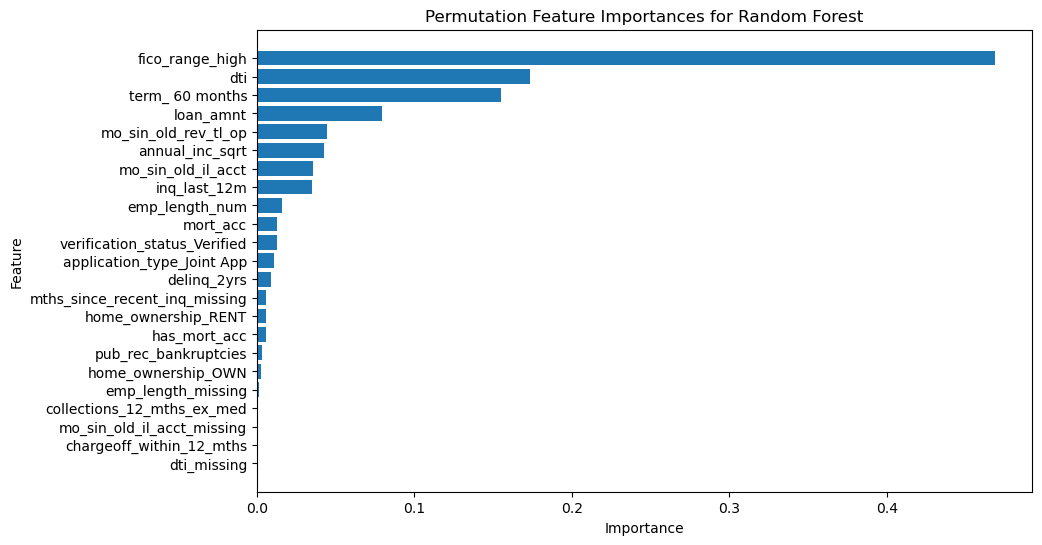

In [224]:
# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importances for Random Forest')
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature at the top
plt.show()

### LIME

LIME explains individual predictions by showing how each feature drives a single loan's interest rate up or down. In this case, an applicant in the test set was used to see these interactions.

Observations:
* Applicant had a low FICO score, which resulted in a higher predicted interest rate.
* Since the loan terms were 36-months, this resulted in lowering the predicted interest rate.
* The applicant's DTI is lower, meaning the predicted interest rate is lowered.

c:\Users\Mike\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<Figure size 500x500 with 0 Axes>

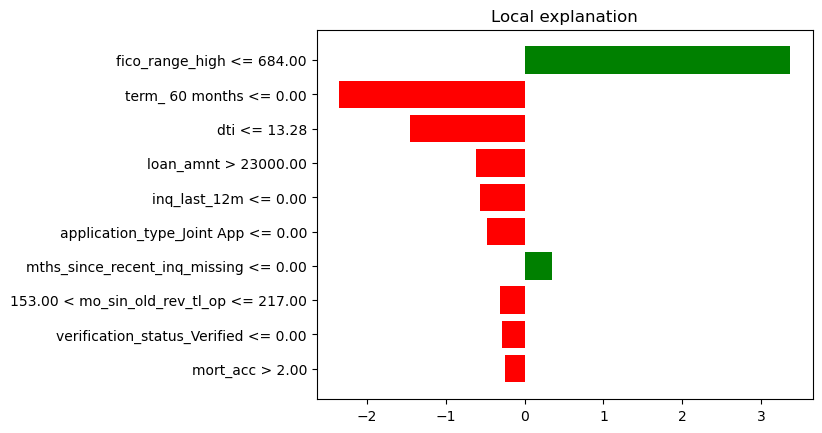

In [225]:
# Prep
feature_names = X_train.columns.tolist()
training_data = X_train.values  

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(training_data, feature_names = feature_names, 
                                                   mode = 'regression',
                                                   discretize_continuous = True,
                                                   random_state = 206)

# Select the first instance from the test set
instance_to_explain = X_test.iloc[1].values

# Generate explanation for the first instance in the test dataset
explanation = explainer.explain_instance(instance_to_explain, rf_model.predict)

# Plot
plt.figure(figsize=(5, 5))
explanation.as_pyplot_figure()
plt.show()


In [226]:
X_test.iloc[1]

chargeoff_within_12_mths             0.000000
collections_12_mths_ex_med           0.000000
delinq_2yrs                          0.000000
dti                                 11.360000
fico_range_high                    684.000000
inq_last_12m                         0.000000
loan_amnt                        25000.000000
mo_sin_old_il_acct                 164.000000
mo_sin_old_rev_tl_op               175.000000
mort_acc                             4.000000
pub_rec_bankruptcies                 1.000000
application_type_Joint App           0.000000
home_ownership_OWN                   0.000000
home_ownership_RENT                  0.000000
term_ 60 months                      0.000000
verification_status_Verified         0.000000
dti_missing                          0.000000
emp_length_num                       0.000000
emp_length_missing                   0.000000
mo_sin_old_il_acct_missing           0.000000
mths_since_recent_inq_missing        0.000000
annual_inc_sqrt                   